In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_5870/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


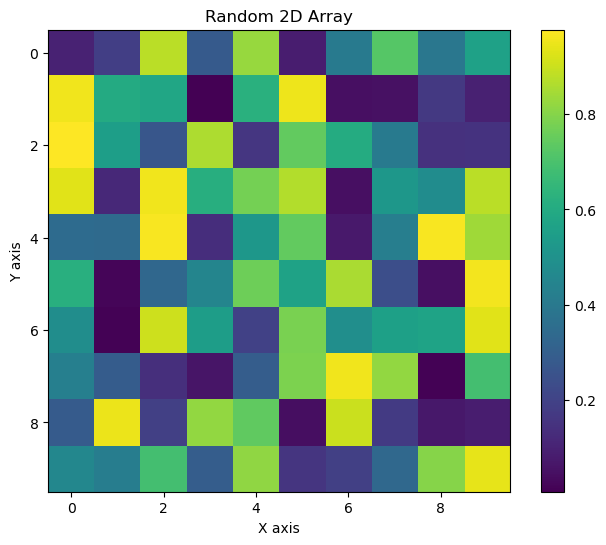

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                 
                    e_transport_swap = 5, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                    e_transport_swap_coin = 0, # swap할 수 있는 coin 개수

                    drop_rate = 0.5, 

                    exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

                    merge_polarities = True, # True # False # tonic dvs dataset 에서 polarities 합치기
                    denoise_on = True, 

                    I_wanna_sweep_at_this_epoch = -1,
                    dvs_duration_domain = [],

                    extra_train_dataset = 0,
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    args_gpu = None
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        args_gpu = args.gpu
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", 
                           include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"),
                           exclude_fn=lambda path: 'logs/' in path or 'net_save/' in path or 'result_save/' in path or 'trying/' in path or 'wandb/' in path or 'private/' in path
                           )
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration,
            exclude_class,
            merge_polarities,
            denoise_on,
            my_seed,
            extra_train_dataset,)
    synapse_fc_out_features = CLASS_NUM
    test_loader_domain_set = []
    test_loader_domain_set.append(test_loader)
    ###########################################################################################################################################
    
    ## 다른 dvs duration domain을 validation set으로 불러오기 ##############################################################
    if len(dvs_duration_domain) > 0:
        for domain in dvs_duration_domain:
            train_loader_domain, test_loader_domain, synapse_conv_in_channels_domain, CLASS_NUM_domain = data_loader(
                    which_data,
                    data_path, 
                    rate_coding, 
                    BATCH, 
                    IMAGE_SIZE,
                    ddp_on,
                    TIME,
                    dvs_clipping,
                    domain,
                    exclude_class,
                    merge_polarities,
                    denoise_on,
                    my_seed,
                    extra_train_dataset,)
            test_loader_domain_set.append(test_loader_domain)
    ######################################################################################################################
    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on,
                        drop_rate).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,
                        drop_rate).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)

    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=epoch_num)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    tr_acc_best = 0
    tr_epoch_loss_temp = 0
    tr_epoch_loss= 0
    val_acc_best = 0
    val_acc_now = 0
    val_loss = 0
    elapsed_time_val = 0
    no_val_best_growth_count = 0
    no_tr_best_growth_count = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    DFA_current = DFA_on
    DFA_toggle = False
    DFA_flag = 1.0 if DFA_current == True else 0.0
    DFA_BP_toggle_trial = 0
    iter_of_val = False
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if (I_wanna_sweep_at_this_epoch == epoch):
            net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
            no_val_best_growth_count = 0
            DFA_current = not DFA_current
            DFA_toggle = True
            DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1
        else:
            if (e_transport_swap > 0 or e_transport_swap_tr > 0):
                assert not (e_transport_swap > 0 and e_transport_swap_tr > 0)
                if e_transport_swap > 0 and no_val_best_growth_count == e_transport_swap :
                    if DFA_BP_toggle_trial < e_transport_swap_coin:
                        net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                        no_val_best_growth_count = 0
                        DFA_current = not DFA_current
                        DFA_toggle = True
                        DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1
                if e_transport_swap_tr > 0 and no_tr_best_growth_count == e_transport_swap_tr:
                    if DFA_BP_toggle_trial < e_transport_swap_coin:
                        net = BP_DFA_SWAP(net, convTrue_fcFalse, single_step, ddp_on, args_gpu)
                        no_tr_best_growth_count = 0
                        DFA_current = not DFA_current
                        DFA_toggle = True
                        DFA_BP_toggle_trial = DFA_BP_toggle_trial + 1

        if ddp_on == False or torch.distributed.get_rank() == 0:
            # print('EPOCH', epoch)
            pass
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            else:
                assert False, 'data length is not 2 or 3'
            #######################################################################################################################
                
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################         
                               
            if merge_polarities == True:
                inputs = inputs[:,:,0,:,:]

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################


            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                iter_loss = criterion(outputs, labels)
                iter_loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                iter_loss = 0.0
                for t in range(TIME):
                    ### input[t] --> net --> output_one_time #########################################
                    outputs_one_time = net(inputs[t])
                    ##################################################################################
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    iter_loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                iter_loss /= TIME
            tr_epoch_loss_temp += iter_loss.data/len(train_loader)

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'epoch-{epoch:<3} iter_acc:{100 * iter_acc:7.2f}%, lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            iter_acc_string2 = f'epoch-{epoch:<3} lr={[f"{lr:9.7f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")
                
            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                domain_index = 0
                val_loss_set = []
                val_acc_now_set = []
                while True:
                    val_loss = 0
                    correct_val = 0
                    total_val = 0
                    test_loader = test_loader_domain_set[domain_index]
                    domain_index = domain_index + 1

                    with torch.no_grad():
                        net.eval() # eval 모드로 바꿔줘야함 
                        for data_val in test_loader:
                            ## data_val loading & semi-pre-processing ##########################################################
                            if len(data_val) == 2:
                                inputs_val, labels_val = data_val
                                # 처리 로직 작성
                            elif len(data_val) == 3:
                                inputs_val, labels_val, x_len = data_val
                                # print('x_len',x_len)
                                # mask = padded_sequence_mask(x_len)
                                # max_time_step = x_len.max()
                                # min_time_step = x_len.min()
                                # B, T, *spatial_dims = inputs_val.shape
                            else:
                                assert False, 'data_val length is not 2 or 3'

                            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                                inputs_val = inputs_val.permute(1, 0, 2, 3, 4)
                            elif rate_coding == True :
                                inputs_val = spikegen.rate(inputs_val, num_steps=TIME)
                            else :
                                inputs_val = inputs_val.repeat(TIME, 1, 1, 1, 1)
                            # inputs_val: [Time, Batch, Channel, Height, Width]  
                            ###################################################################################################

                            inputs_val = inputs_val.to(device)
                            labels_val = labels_val.to(device)
                            real_batch = labels_val.size(0)
                            
                            ## DVS gesture에서 other label자리 매꾸기 ###############
                            if (which_data == 'DVS_GESTURE'):
                                labels_val[labels_val>2] -= 1
                            #######################################################
                            
                            if merge_polarities == True:
                                inputs_val = inputs_val[:,:,0,:,:]

                            ## network 연산 시작 ############################################################################################################
                            if single_step == False:
                                outputs = net(inputs_val.permute(1, 0, 2, 3, 4)) #inputs_val: [Batch, Time, Channel, Height, Width]  
                                val_loss_val += criterion(outputs, labels_val)/len(test_loader)
                            else:
                                outputs_all = []
                                for t in range(TIME):
                                    outputs = net(inputs_val[t])
                                    val_loss_temp = criterion(outputs, labels_val)
                                    outputs_all.append(outputs.detach())
                                    val_loss += (val_loss_temp.data/TIME)/len(test_loader)
                                outputs_all = torch.stack(outputs_all, dim=1)
                                outputs = outputs_all.mean(1)
                            val_loss_set.append(val_loss)
                            #################################################################################################################################

                            _, predicted = torch.max(outputs.data, 1)
                            total_val += real_batch
                            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                            correct_val += (predicted == labels_val).sum().item()

                        val_acc_now = correct_val / total_val
                        # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')
                        val_acc_now_set.append(val_acc_now)

                    if domain_index == len(dvs_duration_domain) + 1:
                        break

                val_loss = val_loss_set[0]
                val_acc_now = val_acc_now_set[0]

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc_best < val_acc_now:
                    val_acc_best = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
                    no_val_best_growth_count = 0
                else:
                    no_val_best_growth_count = no_val_best_growth_count + 1

                if tr_acc_best < tr_acc:
                    tr_acc_best = tr_acc
                    no_tr_best_growth_count = 0
                else:
                    no_tr_best_growth_count = no_tr_best_growth_count + 1

                tr_epoch_loss = tr_epoch_loss_temp
                tr_epoch_loss_temp = 0

                if DFA_toggle == True:
                    DFA_flag = 1.0 - DFA_flag
                    DFA_toggle = False

                iter_of_val = True
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                if iter_of_val == False:
                    iterator.set_description(f"{iter_acc_string}, iter_loss:{iter_loss:10.6f}, val_best:{100 * val_acc_best:7.2f}%")  
                else:
                    iterator.set_description(f"{iter_acc_string2}, tr/val_loss:{tr_epoch_loss:10.6f}/{val_loss:10.6f}, tr:{100 * tr_acc:7.2f}%, val:{100 * val_acc_now:7.2f}%, val_best:{100 * val_acc_best:7.2f}%")  
                    if len(dvs_duration_domain) > 0:
                        dvs_duration_full = [dvs_duration] + dvs_duration_domain
                        print(" | ".join(f"{dvs_duration_full[i]:,}:{val_acc_now_set[i]*100:.2f}%" for i in range(len(val_acc_now_set))))
                    iter_of_val = False
            
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc_best})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
                wandb.log({"DFA_flag": DFA_flag}) # DFA mode 바뀌자 마자 바뀌는 게 아니고 validation 한번 했을 때 바뀜.
                wandb.log({"val_loss": val_loss}) 
                wandb.log({"tr_epoch_loss": tr_epoch_loss}) 
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        # print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
### my_snn control board (Gesture) ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
const2 = False # trace 할거면 True, 안할거면 False

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

if const2 == True:
    const2 = decay
else:
    const2 = 0.0

wandb.init(project= f'my_snn {unique_name}',save_code=True)

my_snn_system(  devices = "4",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 16, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_GESTURE_TONIC',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.2, # 1.3102821334243646,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 2.5, # 2.570969004857107 # sigmoid류에서는 alpha값 4.0, rectangle류에서는 width값 0.5

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',512],
                # cfg = ['M',200],
                # cfg = [200,200],
                cfg = ['M','M',200,200],
                # cfg = ['M','M',1024,512,256,128,64],
                # cfg = [200,200],
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [],        
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = 0.005, #0.1 bptt, #0.01 ottt, # default 0.001  # ottt 0.1 # nda 0.001 # 0.00936191669529645
                epoch_num = 300,
                verbose_interval = 999999999, #이거 걍 건들지마셈 #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #이거 걍 건들지마셈 #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'hard_sigmoid', # 'sigmoid' 'rectangle' 'rough_rectangle' 'hard_sigmoid'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'no', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = 1, #일반적으로 1 또는 2 # 100ms때는 5 # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = 25_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐
                # nmnist 5_000us, gesture는 100_000us, 25_000us

                OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = True, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                 
                e_transport_swap = 0, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_tr = 0, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
                e_transport_swap_coin = 1, # swap할 수 있는 coin 개수

                drop_rate = 0, # drop_rate만큼 0으로 만듦. ex) 0.2면 activation의 20%를 0으로 만듦.

                exclude_class = True, # True # False # gesture에서 10번째 클래스 제외

                merge_polarities = False, # True # False # tonic dvs dataset 에서 polarities 합치기
                denoise_on = True, # True # False

                I_wanna_sweep_at_this_epoch = -1, # 지정 에포크에서 BP와 DFA를 바꿔줌. -1이면 실행 안함.
                dvs_duration_domain = [5_000,10_000,25_000,50_000,75_000,100_000], # domain adaptation할 때 사용할 dvs_duration 리스트
                
                extra_train_dataset = 0,
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling  
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# DDP 실행 코드
'''
ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
'''


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


dataset_hash = 37352dbbe82babbf75912435afa3a81c
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = d592c6461ca1b8f7d04dcafd9aaa6a58
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 278588870fb08b59a8c0781e22c5101c
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 37352dbbe82babbf75912435afa3a81c
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = fff0a228e18447c3a0d34921dc999fdc
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = 7a3b0d3c31c6cf4a0122822ffd404803
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

dataset_hash = c1dc276c1f4bd401dbaf1855ebbd510d
cache path exists

we will exclude the 'other' class. dvsgestrue 10 classes' indices exist. 

DataPa

epoch-0   lr=['0.0050000'], tr/val_loss:  1.850585/  1.401366, tr:  30.03%, val:  52.08%, val_best:  52.08%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:52.08% | 5,000:45.00% | 10,000:50.00% | 25,000:52.08% | 50,000:51.25% | 75,000:51.67% | 100,000:54.58%



epoch-1   lr=['0.0050000'], tr/val_loss:  1.224252/  1.402344, tr:  58.43%, val:  55.42%, val_best:  55.42%: 100%|██████████| 62/62 [00:17<00:00,  3.50it/s]

25,000:55.42% | 5,000:50.42% | 10,000:53.33% | 25,000:55.42% | 50,000:47.92% | 75,000:45.00% | 100,000:44.58%



epoch-2   lr=['0.0050000'], tr/val_loss:  1.072789/  1.352625, tr:  64.35%, val:  52.92%, val_best:  55.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:52.92% | 5,000:51.67% | 10,000:53.33% | 25,000:52.92% | 50,000:50.00% | 75,000:48.33% | 100,000:46.25%



epoch-3   lr=['0.0050000'], tr/val_loss:  0.954945/  1.288709, tr:  70.58%, val:  60.83%, val_best:  60.83%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:60.83% | 5,000:51.25% | 10,000:58.75% | 25,000:60.83% | 50,000:58.75% | 75,000:54.58% | 100,000:50.83%



epoch-4   lr=['0.0050000'], tr/val_loss:  0.724888/  1.308050, tr:  77.94%, val:  62.92%, val_best:  62.92%: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]

25,000:62.92% | 5,000:52.50% | 10,000:61.67% | 25,000:62.92% | 50,000:55.83% | 75,000:51.25% | 100,000:47.92%



epoch-5   lr=['0.0050000'], tr/val_loss:  0.677066/  1.481078, tr:  79.88%, val:  57.08%, val_best:  62.92%: 100%|██████████| 62/62 [00:52<00:00,  1.17it/s]

25,000:57.08% | 5,000:54.58% | 10,000:58.33% | 25,000:57.08% | 50,000:52.92% | 75,000:48.33% | 100,000:46.25%



epoch-6   lr=['0.0050000'], tr/val_loss:  0.529496/  1.392147, tr:  86.31%, val:  60.00%, val_best:  62.92%: 100%|██████████| 62/62 [00:58<00:00,  1.06it/s]

25,000:60.00% | 5,000:56.67% | 10,000:61.67% | 25,000:60.00% | 50,000:55.00% | 75,000:52.50% | 100,000:52.08%



epoch-7   lr=['0.0050000'], tr/val_loss:  0.410226/  1.517262, tr:  91.62%, val:  60.83%, val_best:  62.92%: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]

25,000:60.83% | 5,000:56.25% | 10,000:56.67% | 25,000:60.83% | 50,000:58.33% | 75,000:55.83% | 100,000:51.25%



epoch-8   lr=['0.0050000'], tr/val_loss:  0.352072/  1.450771, tr:  94.28%, val:  64.58%, val_best:  64.58%: 100%|██████████| 62/62 [00:47<00:00,  1.30it/s]

25,000:64.58% | 5,000:52.92% | 10,000:60.42% | 25,000:64.58% | 50,000:64.17% | 75,000:63.33% | 100,000:63.33%



epoch-9   lr=['0.0050000'], tr/val_loss:  0.207651/  1.549381, tr:  98.67%, val:  64.58%, val_best:  64.58%: 100%|██████████| 62/62 [01:03<00:00,  1.02s/it]

25,000:64.58% | 5,000:60.42% | 10,000:63.33% | 25,000:64.58% | 50,000:62.08% | 75,000:60.42% | 100,000:52.08%



epoch-10  lr=['0.0050000'], tr/val_loss:  0.133741/  1.582404, tr:  99.39%, val:  64.17%, val_best:  64.58%: 100%|██████████| 62/62 [00:58<00:00,  1.07it/s]

25,000:64.17% | 5,000:57.08% | 10,000:63.33% | 25,000:64.17% | 50,000:58.75% | 75,000:57.08% | 100,000:54.58%



epoch-11  lr=['0.0050000'], tr/val_loss:  0.094036/  1.650656, tr:  99.90%, val:  67.50%, val_best:  67.50%: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]

25,000:67.50% | 5,000:57.08% | 10,000:62.08% | 25,000:67.50% | 50,000:63.75% | 75,000:62.08% | 100,000:57.08%



epoch-12  lr=['0.0050000'], tr/val_loss:  0.059453/  1.779625, tr:  99.90%, val:  66.67%, val_best:  67.50%:  98%|█████████▊| 61/62 [00:58<00:00,  3.01it/s]

25,000:66.67% | 5,000:57.92% | 10,000:64.17% | 25,000:66.67% | 50,000:64.58% | 75,000:56.67% | 100,000:54.17%


epoch-12  lr=['0.0050000'], tr/val_loss:  0.059453/  1.779625, tr:  99.90%, val:  66.67%, val_best:  67.50%: 100%|██████████| 62/62 [00:58<00:00,  1.05it/s]
epoch-13  lr=['0.0050000'], tr/val_loss:  0.042135/  1.778943, tr: 100.00%, val:  68.33%, val_best:  68.33%: 100%|██████████| 62/62 [00:56<00:00,  1.09it/s]

25,000:68.33% | 5,000:56.67% | 10,000:64.58% | 25,000:68.33% | 50,000:65.00% | 75,000:62.08% | 100,000:58.75%



epoch-14  lr=['0.0050000'], tr/val_loss:  0.029002/  1.846611, tr: 100.00%, val:  67.92%, val_best:  68.33%: 100%|██████████| 62/62 [00:57<00:00,  1.08it/s]

25,000:67.92% | 5,000:57.92% | 10,000:61.67% | 25,000:67.92% | 50,000:64.58% | 75,000:60.00% | 100,000:55.42%



epoch-15  lr=['0.0050000'], tr/val_loss:  0.019001/  1.973551, tr: 100.00%, val:  67.92%, val_best:  68.33%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:67.92% | 5,000:55.42% | 10,000:63.33% | 25,000:67.92% | 50,000:64.17% | 75,000:58.75% | 100,000:57.08%



epoch-16  lr=['0.0050000'], tr/val_loss:  0.013766/  1.961001, tr: 100.00%, val:  67.08%, val_best:  68.33%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:67.08% | 5,000:55.83% | 10,000:63.75% | 25,000:67.08% | 50,000:61.25% | 75,000:60.00% | 100,000:55.42%



epoch-17  lr=['0.0050000'], tr/val_loss:  0.010170/  1.979588, tr: 100.00%, val:  68.75%, val_best:  68.75%:  98%|█████████▊| 61/62 [00:54<00:00,  2.81it/s]

25,000:68.75% | 5,000:55.42% | 10,000:62.08% | 25,000:68.75% | 50,000:62.92% | 75,000:59.17% | 100,000:57.08%


epoch-17  lr=['0.0050000'], tr/val_loss:  0.010170/  1.979588, tr: 100.00%, val:  68.75%, val_best:  68.75%: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]
epoch-18  lr=['0.0050000'], tr/val_loss:  0.009071/  2.002798, tr: 100.00%, val:  67.08%, val_best:  68.75%: 100%|██████████| 62/62 [01:00<00:00,  1.02it/s]

25,000:67.08% | 5,000:58.33% | 10,000:63.75% | 25,000:67.08% | 50,000:65.42% | 75,000:59.17% | 100,000:58.33%



epoch-19  lr=['0.0050000'], tr/val_loss:  0.009360/  2.012625, tr: 100.00%, val:  68.75%, val_best:  68.75%: 100%|██████████| 62/62 [00:50<00:00,  1.24it/s]

25,000:68.75% | 5,000:57.08% | 10,000:62.50% | 25,000:68.75% | 50,000:65.00% | 75,000:60.00% | 100,000:57.08%



epoch-20  lr=['0.0050000'], tr/val_loss:  0.006743/  2.071920, tr: 100.00%, val:  68.75%, val_best:  68.75%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]

25,000:68.75% | 5,000:55.42% | 10,000:63.75% | 25,000:68.75% | 50,000:63.75% | 75,000:58.75% | 100,000:59.17%



epoch-21  lr=['0.0050000'], tr/val_loss:  0.005437/  2.065722, tr: 100.00%, val:  69.58%, val_best:  69.58%: 100%|██████████| 62/62 [00:58<00:00,  1.06it/s]

25,000:69.58% | 5,000:56.25% | 10,000:62.50% | 25,000:69.58% | 50,000:65.00% | 75,000:61.25% | 100,000:59.17%



epoch-22  lr=['0.0050000'], tr/val_loss:  0.004843/  2.081233, tr: 100.00%, val:  69.58%, val_best:  69.58%: 100%|██████████| 62/62 [00:47<00:00,  1.31it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:59.58% | 100,000:59.17%



epoch-23  lr=['0.0050000'], tr/val_loss:  0.004332/  2.091564, tr: 100.00%, val:  68.75%, val_best:  69.58%: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]

25,000:68.75% | 5,000:57.08% | 10,000:63.75% | 25,000:68.75% | 50,000:64.58% | 75,000:59.58% | 100,000:59.58%



epoch-24  lr=['0.0050000'], tr/val_loss:  0.004094/  2.129364, tr: 100.00%, val:  68.75%, val_best:  69.58%: 100%|██████████| 62/62 [00:56<00:00,  1.10it/s]

25,000:68.75% | 5,000:56.67% | 10,000:64.58% | 25,000:68.75% | 50,000:63.33% | 75,000:59.58% | 100,000:57.92%



epoch-25  lr=['0.0050000'], tr/val_loss:  0.003557/  2.154205, tr: 100.00%, val:  68.75%, val_best:  69.58%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:68.75% | 5,000:56.25% | 10,000:62.92% | 25,000:68.75% | 50,000:64.58% | 75,000:59.17% | 100,000:56.67%



epoch-26  lr=['0.0050000'], tr/val_loss:  0.003462/  2.161838, tr: 100.00%, val:  70.00%, val_best:  70.00%: 100%|██████████| 62/62 [00:46<00:00,  1.33it/s]

25,000:70.00% | 5,000:56.25% | 10,000:62.92% | 25,000:70.00% | 50,000:63.33% | 75,000:59.17% | 100,000:57.50%



epoch-27  lr=['0.0050000'], tr/val_loss:  0.003056/  2.166391, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.75% | 25,000:69.17% | 50,000:65.42% | 75,000:59.17% | 100,000:57.92%



epoch-28  lr=['0.0050000'], tr/val_loss:  0.002795/  2.185616, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:68.75% | 5,000:56.67% | 10,000:64.17% | 25,000:68.75% | 50,000:64.58% | 75,000:59.58% | 100,000:57.50%



epoch-29  lr=['0.0050000'], tr/val_loss:  0.002669/  2.200706, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:45<00:00,  1.37it/s]

25,000:68.75% | 5,000:55.83% | 10,000:63.33% | 25,000:68.75% | 50,000:64.17% | 75,000:59.17% | 100,000:58.75%



epoch-30  lr=['0.0050000'], tr/val_loss:  0.002549/  2.213443, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:55.42% | 10,000:64.17% | 25,000:69.17% | 50,000:64.17% | 75,000:57.50% | 100,000:58.75%



epoch-31  lr=['0.0050000'], tr/val_loss:  0.002405/  2.227224, tr: 100.00%, val:  69.58%, val_best:  70.00%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:64.58% | 75,000:60.00% | 100,000:57.92%



epoch-32  lr=['0.0050000'], tr/val_loss:  0.002237/  2.246560, tr: 100.00%, val:  69.17%, val_best:  70.00%:  98%|█████████▊| 61/62 [00:47<00:00,  2.26it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.75% | 25,000:69.17% | 50,000:65.00% | 75,000:58.75% | 100,000:58.75%


epoch-32  lr=['0.0050000'], tr/val_loss:  0.002237/  2.246560, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]
epoch-33  lr=['0.0050000'], tr/val_loss:  0.002077/  2.263775, tr: 100.00%, val:  69.58%, val_best:  70.00%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.58% | 5,000:57.08% | 10,000:63.75% | 25,000:69.58% | 50,000:65.00% | 75,000:58.33% | 100,000:57.50%



epoch-34  lr=['0.0050000'], tr/val_loss:  0.002059/  2.272845, tr: 100.00%, val:  68.33%, val_best:  70.00%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:68.33% | 5,000:57.08% | 10,000:62.08% | 25,000:68.33% | 50,000:64.17% | 75,000:57.92% | 100,000:58.33%



epoch-35  lr=['0.0050000'], tr/val_loss:  0.001978/  2.287046, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:57.08% | 10,000:62.92% | 25,000:69.17% | 50,000:64.17% | 75,000:58.33% | 100,000:58.33%



epoch-36  lr=['0.0050000'], tr/val_loss:  0.001935/  2.295331, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:68.75% | 5,000:56.67% | 10,000:62.50% | 25,000:68.75% | 50,000:64.17% | 75,000:58.75% | 100,000:58.33%



epoch-37  lr=['0.0050000'], tr/val_loss:  0.001863/  2.306620, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:49<00:00,  1.24it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:59.58% | 100,000:57.92%



epoch-38  lr=['0.0050000'], tr/val_loss:  0.001772/  2.313845, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:68.75% | 5,000:55.42% | 10,000:63.33% | 25,000:68.75% | 50,000:63.75% | 75,000:59.58% | 100,000:57.50%



epoch-39  lr=['0.0050000'], tr/val_loss:  0.001697/  2.304920, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.33% | 25,000:69.17% | 50,000:64.17% | 75,000:59.17% | 100,000:57.92%



epoch-40  lr=['0.0050000'], tr/val_loss:  0.001642/  2.323320, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]

25,000:69.17% | 5,000:55.42% | 10,000:63.75% | 25,000:69.17% | 50,000:63.33% | 75,000:59.17% | 100,000:57.50%



epoch-41  lr=['0.0050000'], tr/val_loss:  0.001561/  2.326513, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:55.42% | 10,000:62.50% | 25,000:69.17% | 50,000:63.75% | 75,000:61.25% | 100,000:58.33%



epoch-42  lr=['0.0050000'], tr/val_loss:  0.001538/  2.336212, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:44<00:00,  1.38it/s]

25,000:68.75% | 5,000:55.83% | 10,000:62.08% | 25,000:68.75% | 50,000:63.33% | 75,000:60.83% | 100,000:57.50%



epoch-43  lr=['0.0050000'], tr/val_loss:  0.001503/  2.348796, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:68.75% | 5,000:55.83% | 10,000:62.08% | 25,000:68.75% | 50,000:64.17% | 75,000:60.00% | 100,000:58.75%



epoch-44  lr=['0.0050000'], tr/val_loss:  0.001455/  2.370270, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:68.75% | 5,000:56.67% | 10,000:61.25% | 25,000:68.75% | 50,000:63.33% | 75,000:58.33% | 100,000:58.75%



epoch-45  lr=['0.0050000'], tr/val_loss:  0.001461/  2.378269, tr: 100.00%, val:  67.92%, val_best:  70.00%: 100%|██████████| 62/62 [00:56<00:00,  1.09it/s]

25,000:67.92% | 5,000:56.67% | 10,000:62.08% | 25,000:67.92% | 50,000:65.00% | 75,000:59.17% | 100,000:59.17%



epoch-46  lr=['0.0050000'], tr/val_loss:  0.001424/  2.379509, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:56<00:00,  1.09it/s]

25,000:68.75% | 5,000:56.67% | 10,000:62.50% | 25,000:68.75% | 50,000:62.92% | 75,000:58.75% | 100,000:59.17%



epoch-47  lr=['0.0050000'], tr/val_loss:  0.001331/  2.386146, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:68.75% | 5,000:57.08% | 10,000:62.50% | 25,000:68.75% | 50,000:62.92% | 75,000:58.75% | 100,000:59.17%



epoch-48  lr=['0.0050000'], tr/val_loss:  0.001358/  2.382361, tr: 100.00%, val:  67.50%, val_best:  70.00%: 100%|██████████| 62/62 [00:46<00:00,  1.32it/s]

25,000:67.50% | 5,000:57.50% | 10,000:62.08% | 25,000:67.50% | 50,000:63.33% | 75,000:60.42% | 100,000:58.75%



epoch-49  lr=['0.0050000'], tr/val_loss:  0.001349/  2.388836, tr: 100.00%, val:  68.33%, val_best:  70.00%: 100%|██████████| 62/62 [00:43<00:00,  1.43it/s]

25,000:68.33% | 5,000:57.50% | 10,000:62.92% | 25,000:68.33% | 50,000:63.33% | 75,000:60.00% | 100,000:58.75%



epoch-50  lr=['0.0050000'], tr/val_loss:  0.001281/  2.395782, tr: 100.00%, val:  68.33%, val_best:  70.00%: 100%|██████████| 62/62 [00:57<00:00,  1.07it/s]

25,000:68.33% | 5,000:57.50% | 10,000:62.92% | 25,000:68.33% | 50,000:63.75% | 75,000:60.00% | 100,000:58.33%



epoch-51  lr=['0.0050000'], tr/val_loss:  0.001229/  2.391002, tr: 100.00%, val:  67.92%, val_best:  70.00%: 100%|██████████| 62/62 [00:54<00:00,  1.14it/s]

25,000:67.92% | 5,000:57.08% | 10,000:62.50% | 25,000:67.92% | 50,000:63.75% | 75,000:60.42% | 100,000:58.33%



epoch-52  lr=['0.0050000'], tr/val_loss:  0.001247/  2.405416, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:46<00:00,  1.32it/s]

25,000:69.17% | 5,000:57.08% | 10,000:62.50% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:58.33%



epoch-53  lr=['0.0050000'], tr/val_loss:  0.001198/  2.404765, tr: 100.00%, val:  68.33%, val_best:  70.00%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:68.33% | 5,000:57.08% | 10,000:62.08% | 25,000:68.33% | 50,000:63.33% | 75,000:59.58% | 100,000:58.75%



epoch-54  lr=['0.0050000'], tr/val_loss:  0.001174/  2.416027, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:52<00:00,  1.17it/s]

25,000:68.75% | 5,000:57.50% | 10,000:62.50% | 25,000:68.75% | 50,000:65.42% | 75,000:60.42% | 100,000:58.75%



epoch-55  lr=['0.0050000'], tr/val_loss:  0.001134/  2.419390, tr: 100.00%, val:  68.33%, val_best:  70.00%: 100%|██████████| 62/62 [00:54<00:00,  1.14it/s]

25,000:68.33% | 5,000:57.92% | 10,000:61.67% | 25,000:68.33% | 50,000:65.42% | 75,000:59.58% | 100,000:58.33%



epoch-56  lr=['0.0050000'], tr/val_loss:  0.001111/  2.434159, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:69.17% | 5,000:57.08% | 10,000:62.08% | 25,000:69.17% | 50,000:65.00% | 75,000:61.25% | 100,000:58.33%



epoch-57  lr=['0.0050000'], tr/val_loss:  0.001079/  2.439562, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:68.75% | 5,000:57.08% | 10,000:61.67% | 25,000:68.75% | 50,000:65.42% | 75,000:60.83% | 100,000:58.75%



epoch-58  lr=['0.0050000'], tr/val_loss:  0.001074/  2.440798, tr: 100.00%, val:  68.33%, val_best:  70.00%: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

25,000:68.33% | 5,000:57.50% | 10,000:62.08% | 25,000:68.33% | 50,000:65.00% | 75,000:60.83% | 100,000:58.33%



epoch-59  lr=['0.0050000'], tr/val_loss:  0.001062/  2.453918, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:41<00:00,  1.49it/s]

25,000:68.75% | 5,000:57.50% | 10,000:62.92% | 25,000:68.75% | 50,000:65.00% | 75,000:60.42% | 100,000:58.33%



epoch-60  lr=['0.0050000'], tr/val_loss:  0.001039/  2.453372, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]

25,000:69.17% | 5,000:56.67% | 10,000:62.50% | 25,000:69.17% | 50,000:65.00% | 75,000:59.58% | 100,000:57.92%



epoch-61  lr=['0.0050000'], tr/val_loss:  0.001059/  2.457651, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:57<00:00,  1.09it/s]

25,000:68.75% | 5,000:57.08% | 10,000:63.33% | 25,000:68.75% | 50,000:64.17% | 75,000:59.58% | 100,000:57.92%



epoch-62  lr=['0.0050000'], tr/val_loss:  0.001069/  2.454921, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:51<00:00,  1.19it/s]

25,000:69.17% | 5,000:56.67% | 10,000:62.50% | 25,000:69.17% | 50,000:64.17% | 75,000:59.58% | 100,000:58.33%



epoch-63  lr=['0.0050000'], tr/val_loss:  0.001015/  2.457355, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]

25,000:69.17% | 5,000:56.25% | 10,000:62.08% | 25,000:69.17% | 50,000:64.58% | 75,000:60.42% | 100,000:58.33%



epoch-64  lr=['0.0050000'], tr/val_loss:  0.001007/  2.458673, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.17% | 5,000:56.25% | 10,000:62.08% | 25,000:69.17% | 50,000:65.42% | 75,000:60.00% | 100,000:57.92%



epoch-65  lr=['0.0050000'], tr/val_loss:  0.001165/  2.471735, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]

25,000:69.17% | 5,000:56.67% | 10,000:62.92% | 25,000:69.17% | 50,000:65.00% | 75,000:58.75% | 100,000:57.92%



epoch-66  lr=['0.0050000'], tr/val_loss:  0.000933/  2.470896, tr: 100.00%, val:  68.33%, val_best:  70.00%: 100%|██████████| 62/62 [00:51<00:00,  1.19it/s]

25,000:68.33% | 5,000:56.67% | 10,000:62.92% | 25,000:68.33% | 50,000:65.42% | 75,000:59.58% | 100,000:57.92%



epoch-67  lr=['0.0050000'], tr/val_loss:  0.000945/  2.475642, tr: 100.00%, val:  69.58%, val_best:  70.00%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.58% | 5,000:56.67% | 10,000:62.92% | 25,000:69.58% | 50,000:65.83% | 75,000:59.58% | 100,000:57.92%



epoch-68  lr=['0.0050000'], tr/val_loss:  0.000942/  2.478078, tr: 100.00%, val:  69.58%, val_best:  70.00%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.58% | 5,000:56.25% | 10,000:62.92% | 25,000:69.58% | 50,000:64.17% | 75,000:60.42% | 100,000:57.50%



epoch-69  lr=['0.0050000'], tr/val_loss:  0.000945/  2.488122, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:45<00:00,  1.37it/s]

25,000:68.75% | 5,000:56.25% | 10,000:63.33% | 25,000:68.75% | 50,000:65.42% | 75,000:60.00% | 100,000:57.50%



epoch-70  lr=['0.0050000'], tr/val_loss:  0.000909/  2.496277, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:68.75% | 5,000:56.25% | 10,000:62.92% | 25,000:68.75% | 50,000:64.58% | 75,000:60.42% | 100,000:57.08%



epoch-71  lr=['0.0050000'], tr/val_loss:  0.000883/  2.496562, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:51<00:00,  1.22it/s]

25,000:68.75% | 5,000:55.42% | 10,000:63.33% | 25,000:68.75% | 50,000:65.00% | 75,000:60.00% | 100,000:57.08%



epoch-72  lr=['0.0050000'], tr/val_loss:  0.000863/  2.500647, tr: 100.00%, val:  69.58%, val_best:  70.00%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:69.58% | 5,000:56.25% | 10,000:62.92% | 25,000:69.58% | 50,000:65.00% | 75,000:60.00% | 100,000:57.50%



epoch-73  lr=['0.0050000'], tr/val_loss:  0.000847/  2.497086, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [01:05<00:00,  1.05s/it]

25,000:69.17% | 5,000:56.25% | 10,000:62.50% | 25,000:69.17% | 50,000:64.58% | 75,000:60.42% | 100,000:56.67%



epoch-74  lr=['0.0050000'], tr/val_loss:  0.000832/  2.502179, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:58<00:00,  1.05it/s]

25,000:69.17% | 5,000:56.67% | 10,000:62.50% | 25,000:69.17% | 50,000:65.00% | 75,000:59.58% | 100,000:57.50%



epoch-75  lr=['0.0050000'], tr/val_loss:  0.000799/  2.490212, tr: 100.00%, val:  68.75%, val_best:  70.00%: 100%|██████████| 62/62 [00:57<00:00,  1.08it/s]

25,000:68.75% | 5,000:55.83% | 10,000:62.92% | 25,000:68.75% | 50,000:64.58% | 75,000:60.00% | 100,000:56.25%



epoch-76  lr=['0.0050000'], tr/val_loss:  0.000816/  2.504179, tr: 100.00%, val:  69.17%, val_best:  70.00%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:69.17% | 5,000:56.25% | 10,000:62.50% | 25,000:69.17% | 50,000:64.17% | 75,000:60.00% | 100,000:57.08%



epoch-77  lr=['0.0050000'], tr/val_loss:  0.000803/  2.500580, tr: 100.00%, val:  69.58%, val_best:  70.00%: 100%|██████████| 62/62 [00:53<00:00,  1.17it/s]

25,000:69.58% | 5,000:57.08% | 10,000:62.50% | 25,000:69.58% | 50,000:64.58% | 75,000:59.58% | 100,000:57.08%



epoch-78  lr=['0.0050000'], tr/val_loss:  0.000772/  2.503165, tr: 100.00%, val:  70.42%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

25,000:70.42% | 5,000:57.08% | 10,000:62.92% | 25,000:70.42% | 50,000:63.75% | 75,000:60.00% | 100,000:57.50%



epoch-79  lr=['0.0050000'], tr/val_loss:  0.000778/  2.509558, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:70.00% | 5,000:57.50% | 10,000:62.92% | 25,000:70.00% | 50,000:63.75% | 75,000:59.58% | 100,000:57.50%



epoch-80  lr=['0.0050000'], tr/val_loss:  0.000773/  2.508725, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:57<00:00,  1.09it/s]

25,000:69.58% | 5,000:57.08% | 10,000:62.50% | 25,000:69.58% | 50,000:63.75% | 75,000:60.00% | 100,000:57.92%



epoch-81  lr=['0.0050000'], tr/val_loss:  0.000765/  2.507782, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.14it/s]

25,000:70.00% | 5,000:57.08% | 10,000:62.08% | 25,000:70.00% | 50,000:64.17% | 75,000:60.42% | 100,000:57.92%



epoch-82  lr=['0.0050000'], tr/val_loss:  0.000760/  2.515716, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.29it/s]

25,000:69.58% | 5,000:57.08% | 10,000:62.50% | 25,000:69.58% | 50,000:64.17% | 75,000:60.42% | 100,000:57.92%



epoch-83  lr=['0.0050000'], tr/val_loss:  0.000749/  2.524515, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]

25,000:70.00% | 5,000:57.50% | 10,000:62.92% | 25,000:70.00% | 50,000:64.58% | 75,000:60.42% | 100,000:58.33%



epoch-84  lr=['0.0050000'], tr/val_loss:  0.000742/  2.528398, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:57<00:00,  1.08it/s]

25,000:69.17% | 5,000:57.50% | 10,000:62.50% | 25,000:69.17% | 50,000:65.42% | 75,000:60.00% | 100,000:57.50%



epoch-85  lr=['0.0050000'], tr/val_loss:  0.000736/  2.530390, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:57.50% | 10,000:62.92% | 25,000:69.17% | 50,000:64.58% | 75,000:60.00% | 100,000:57.92%



epoch-86  lr=['0.0050000'], tr/val_loss:  0.000731/  2.531185, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

25,000:69.17% | 5,000:58.33% | 10,000:63.33% | 25,000:69.17% | 50,000:64.58% | 75,000:60.00% | 100,000:57.08%



epoch-87  lr=['0.0050000'], tr/val_loss:  0.000731/  2.534588, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

25,000:69.17% | 5,000:57.92% | 10,000:63.33% | 25,000:69.17% | 50,000:65.00% | 75,000:60.42% | 100,000:57.50%



epoch-88  lr=['0.0050000'], tr/val_loss:  0.000718/  2.530431, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]

25,000:70.00% | 5,000:57.92% | 10,000:62.92% | 25,000:70.00% | 50,000:64.58% | 75,000:60.00% | 100,000:57.08%



epoch-89  lr=['0.0050000'], tr/val_loss:  0.000697/  2.531584, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.13it/s]

25,000:69.58% | 5,000:57.92% | 10,000:62.92% | 25,000:69.58% | 50,000:65.00% | 75,000:60.00% | 100,000:57.08%



epoch-90  lr=['0.0050000'], tr/val_loss:  0.000717/  2.529842, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:69.17% | 5,000:57.50% | 10,000:62.50% | 25,000:69.17% | 50,000:65.42% | 75,000:60.83% | 100,000:57.92%



epoch-91  lr=['0.0050000'], tr/val_loss:  0.000718/  2.541772, tr: 100.00%, val:  70.42%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

25,000:70.42% | 5,000:57.08% | 10,000:62.50% | 25,000:70.42% | 50,000:65.00% | 75,000:60.42% | 100,000:57.50%



epoch-92  lr=['0.0050000'], tr/val_loss:  0.000709/  2.547977, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:56<00:00,  1.09it/s]

25,000:70.00% | 5,000:57.08% | 10,000:62.50% | 25,000:70.00% | 50,000:65.42% | 75,000:61.25% | 100,000:58.33%



epoch-93  lr=['0.0050000'], tr/val_loss:  0.000682/  2.551696, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:69.58% | 5,000:56.67% | 10,000:62.08% | 25,000:69.58% | 50,000:64.58% | 75,000:60.00% | 100,000:57.92%



epoch-94  lr=['0.0050000'], tr/val_loss:  0.000682/  2.560724, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.17it/s]

25,000:70.00% | 5,000:57.08% | 10,000:62.50% | 25,000:70.00% | 50,000:64.58% | 75,000:60.42% | 100,000:57.92%



epoch-95  lr=['0.0050000'], tr/val_loss:  0.000669/  2.563307, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:27<00:00,  2.23it/s]

25,000:69.58% | 5,000:57.08% | 10,000:62.50% | 25,000:69.58% | 50,000:64.58% | 75,000:60.83% | 100,000:57.50%



epoch-96  lr=['0.0050000'], tr/val_loss:  0.000664/  2.566219, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:14<00:00,  4.14it/s]

25,000:69.58% | 5,000:57.08% | 10,000:62.50% | 25,000:69.58% | 50,000:64.58% | 75,000:60.83% | 100,000:58.75%



epoch-97  lr=['0.0050000'], tr/val_loss:  0.000655/  2.558741, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:14<00:00,  4.19it/s]

25,000:70.00% | 5,000:57.08% | 10,000:62.08% | 25,000:70.00% | 50,000:64.17% | 75,000:60.83% | 100,000:58.33%



epoch-98  lr=['0.0050000'], tr/val_loss:  0.000661/  2.568576, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]

25,000:70.00% | 5,000:57.50% | 10,000:62.50% | 25,000:70.00% | 50,000:64.58% | 75,000:60.83% | 100,000:57.92%



epoch-99  lr=['0.0050000'], tr/val_loss:  0.000652/  2.577755, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:15<00:00,  3.89it/s]

25,000:70.00% | 5,000:57.08% | 10,000:62.92% | 25,000:70.00% | 50,000:63.75% | 75,000:60.42% | 100,000:57.92%



epoch-100 lr=['0.0050000'], tr/val_loss:  0.000655/  2.578117, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:14<00:00,  4.15it/s]

25,000:69.58% | 5,000:57.50% | 10,000:62.92% | 25,000:69.58% | 50,000:63.33% | 75,000:60.42% | 100,000:58.33%



epoch-101 lr=['0.0050000'], tr/val_loss:  0.000689/  2.568475, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:14<00:00,  4.18it/s]

25,000:70.00% | 5,000:57.08% | 10,000:62.92% | 25,000:70.00% | 50,000:63.75% | 75,000:60.83% | 100,000:57.50%



epoch-102 lr=['0.0050000'], tr/val_loss:  0.000654/  2.573317, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s]

25,000:70.00% | 5,000:57.08% | 10,000:63.33% | 25,000:70.00% | 50,000:64.17% | 75,000:60.83% | 100,000:57.92%



epoch-103 lr=['0.0050000'], tr/val_loss:  0.000659/  2.575275, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:14<00:00,  4.27it/s]

25,000:70.00% | 5,000:57.50% | 10,000:63.75% | 25,000:70.00% | 50,000:64.17% | 75,000:60.83% | 100,000:57.92%



epoch-104 lr=['0.0050000'], tr/val_loss:  0.000646/  2.578844, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:15<00:00,  4.09it/s]

25,000:69.17% | 5,000:57.08% | 10,000:62.92% | 25,000:69.17% | 50,000:63.75% | 75,000:60.42% | 100,000:57.92%



epoch-105 lr=['0.0050000'], tr/val_loss:  0.000637/  2.584938, tr: 100.00%, val:  69.17%, val_best:  70.42%:  98%|█████████▊| 61/62 [00:14<00:00, 10.89it/s]

25,000:69.17% | 5,000:57.08% | 10,000:63.75% | 25,000:69.17% | 50,000:63.75% | 75,000:60.00% | 100,000:57.92%


epoch-105 lr=['0.0050000'], tr/val_loss:  0.000637/  2.584938, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:15<00:00,  3.89it/s]
epoch-106 lr=['0.0050000'], tr/val_loss:  0.000636/  2.585470, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:68.75% | 5,000:57.08% | 10,000:63.33% | 25,000:68.75% | 50,000:63.33% | 75,000:60.42% | 100,000:57.08%



epoch-107 lr=['0.0050000'], tr/val_loss:  0.000636/  2.582752, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:56<00:00,  1.10it/s]

25,000:68.75% | 5,000:57.50% | 10,000:63.33% | 25,000:68.75% | 50,000:64.17% | 75,000:61.25% | 100,000:57.08%



epoch-108 lr=['0.0050000'], tr/val_loss:  0.000580/  2.583894, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.17% | 5,000:57.08% | 10,000:63.33% | 25,000:69.17% | 50,000:62.92% | 75,000:60.42% | 100,000:57.50%



epoch-109 lr=['0.0050000'], tr/val_loss:  0.000532/  2.595963, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]

25,000:68.75% | 5,000:57.50% | 10,000:63.33% | 25,000:68.75% | 50,000:64.17% | 75,000:60.42% | 100,000:57.50%



epoch-110 lr=['0.0050000'], tr/val_loss:  0.000537/  2.597465, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.32it/s]

25,000:68.75% | 5,000:56.67% | 10,000:64.17% | 25,000:68.75% | 50,000:65.00% | 75,000:60.42% | 100,000:57.50%



epoch-111 lr=['0.0050000'], tr/val_loss:  0.000479/  2.593369, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.24it/s]

25,000:68.75% | 5,000:56.67% | 10,000:63.33% | 25,000:68.75% | 50,000:64.58% | 75,000:60.83% | 100,000:57.08%



epoch-112 lr=['0.0050000'], tr/val_loss:  0.000502/  2.586239, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:68.75% | 5,000:57.08% | 10,000:63.33% | 25,000:68.75% | 50,000:64.58% | 75,000:60.83% | 100,000:57.08%



epoch-113 lr=['0.0050000'], tr/val_loss:  0.000518/  2.589162, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:69.58% | 5,000:57.50% | 10,000:63.75% | 25,000:69.58% | 50,000:65.00% | 75,000:60.83% | 100,000:57.50%



epoch-114 lr=['0.0050000'], tr/val_loss:  0.000556/  2.590800, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.24it/s]

25,000:70.00% | 5,000:57.92% | 10,000:63.75% | 25,000:70.00% | 50,000:64.58% | 75,000:60.00% | 100,000:57.50%



epoch-115 lr=['0.0050000'], tr/val_loss:  0.000458/  2.594309, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]

25,000:69.17% | 5,000:57.92% | 10,000:64.17% | 25,000:69.17% | 50,000:64.58% | 75,000:60.00% | 100,000:57.50%



epoch-116 lr=['0.0050000'], tr/val_loss:  0.000458/  2.597883, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.17% | 5,000:57.92% | 10,000:63.75% | 25,000:69.17% | 50,000:65.00% | 75,000:60.83% | 100,000:57.92%



epoch-117 lr=['0.0050000'], tr/val_loss:  0.000447/  2.606927, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:69.58% | 5,000:57.50% | 10,000:63.33% | 25,000:69.58% | 50,000:64.58% | 75,000:60.00% | 100,000:57.92%



epoch-118 lr=['0.0050000'], tr/val_loss:  0.000447/  2.599068, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:69.58% | 5,000:57.08% | 10,000:63.33% | 25,000:69.58% | 50,000:65.42% | 75,000:59.58% | 100,000:57.50%



epoch-119 lr=['0.0050000'], tr/val_loss:  0.000387/  2.600279, tr: 100.00%, val:  70.42%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:70.42% | 5,000:57.08% | 10,000:64.17% | 25,000:70.42% | 50,000:65.00% | 75,000:59.58% | 100,000:57.50%



epoch-120 lr=['0.0050000'], tr/val_loss:  0.000365/  2.606587, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.75% | 25,000:70.00% | 50,000:64.17% | 75,000:60.00% | 100,000:57.50%



epoch-121 lr=['0.0050000'], tr/val_loss:  0.000382/  2.600180, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.24it/s]

25,000:69.58% | 5,000:57.08% | 10,000:63.75% | 25,000:69.58% | 50,000:64.58% | 75,000:60.42% | 100,000:57.50%



epoch-122 lr=['0.0050000'], tr/val_loss:  0.000380/  2.601662, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.29it/s]

25,000:68.75% | 5,000:56.67% | 10,000:64.17% | 25,000:68.75% | 50,000:64.17% | 75,000:60.42% | 100,000:57.50%



epoch-123 lr=['0.0050000'], tr/val_loss:  0.000371/  2.610730, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:56<00:00,  1.10it/s]

25,000:68.75% | 5,000:56.25% | 10,000:64.17% | 25,000:68.75% | 50,000:64.58% | 75,000:60.00% | 100,000:57.50%



epoch-124 lr=['0.0050000'], tr/val_loss:  0.000373/  2.611760, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]

25,000:69.58% | 5,000:56.67% | 10,000:64.17% | 25,000:69.58% | 50,000:65.00% | 75,000:60.42% | 100,000:57.92%



epoch-125 lr=['0.0050000'], tr/val_loss:  0.000359/  2.615037, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.15it/s]

25,000:69.58% | 5,000:57.08% | 10,000:64.17% | 25,000:69.58% | 50,000:64.17% | 75,000:60.42% | 100,000:57.50%



epoch-126 lr=['0.0050000'], tr/val_loss:  0.000359/  2.614572, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.17it/s]

25,000:69.58% | 5,000:57.50% | 10,000:63.75% | 25,000:69.58% | 50,000:64.58% | 75,000:60.42% | 100,000:57.92%



epoch-127 lr=['0.0050000'], tr/val_loss:  0.000336/  2.618434, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:69.58% | 5,000:57.50% | 10,000:63.75% | 25,000:69.58% | 50,000:64.17% | 75,000:60.42% | 100,000:57.50%



epoch-128 lr=['0.0050000'], tr/val_loss:  0.000344/  2.618770, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:69.58% | 5,000:57.50% | 10,000:64.17% | 25,000:69.58% | 50,000:63.75% | 75,000:60.00% | 100,000:57.50%



epoch-129 lr=['0.0050000'], tr/val_loss:  0.000339/  2.616282, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.58% | 5,000:57.50% | 10,000:64.17% | 25,000:69.58% | 50,000:65.00% | 75,000:60.00% | 100,000:57.50%



epoch-130 lr=['0.0050000'], tr/val_loss:  0.000330/  2.618689, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.24it/s]

25,000:69.58% | 5,000:57.08% | 10,000:63.75% | 25,000:69.58% | 50,000:63.75% | 75,000:60.00% | 100,000:57.50%



epoch-131 lr=['0.0050000'], tr/val_loss:  0.000322/  2.626324, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:59<00:00,  1.04it/s]

25,000:69.17% | 5,000:57.08% | 10,000:63.75% | 25,000:69.17% | 50,000:63.75% | 75,000:60.00% | 100,000:57.92%



epoch-132 lr=['0.0050000'], tr/val_loss:  0.000312/  2.626462, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:69.58% | 5,000:57.08% | 10,000:64.17% | 25,000:69.58% | 50,000:63.75% | 75,000:59.58% | 100,000:57.50%



epoch-133 lr=['0.0050000'], tr/val_loss:  0.000315/  2.630444, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:43<00:00,  1.42it/s]

25,000:69.17% | 5,000:57.50% | 10,000:63.33% | 25,000:69.17% | 50,000:65.00% | 75,000:59.58% | 100,000:57.08%



epoch-134 lr=['0.0050000'], tr/val_loss:  0.000323/  2.637538, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:44<00:00,  1.38it/s]

25,000:69.17% | 5,000:57.08% | 10,000:64.17% | 25,000:69.17% | 50,000:65.00% | 75,000:59.58% | 100,000:57.08%



epoch-135 lr=['0.0050000'], tr/val_loss:  0.000310/  2.637602, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.30it/s]

25,000:69.17% | 5,000:57.50% | 10,000:64.17% | 25,000:69.17% | 50,000:64.17% | 75,000:60.00% | 100,000:57.50%



epoch-136 lr=['0.0050000'], tr/val_loss:  0.000301/  2.641351, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.13it/s]

25,000:70.00% | 5,000:57.50% | 10,000:64.17% | 25,000:70.00% | 50,000:63.33% | 75,000:60.00% | 100,000:56.67%



epoch-137 lr=['0.0050000'], tr/val_loss:  0.000307/  2.645160, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:57.50% | 10,000:64.17% | 25,000:69.17% | 50,000:63.33% | 75,000:60.42% | 100,000:56.67%



epoch-138 lr=['0.0050000'], tr/val_loss:  0.000300/  2.648681, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:69.17% | 5,000:57.50% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:56.67%



epoch-139 lr=['0.0050000'], tr/val_loss:  0.000305/  2.653929, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.14it/s]

25,000:69.17% | 5,000:57.08% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:59.58% | 100,000:56.67%



epoch-140 lr=['0.0050000'], tr/val_loss:  0.000297/  2.656823, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.75% | 25,000:69.17% | 50,000:63.75% | 75,000:60.00% | 100,000:57.50%



epoch-141 lr=['0.0050000'], tr/val_loss:  0.000301/  2.652759, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:46<00:00,  1.33it/s]

25,000:69.17% | 5,000:56.67% | 10,000:64.17% | 25,000:69.17% | 50,000:62.92% | 75,000:60.00% | 100,000:57.08%



epoch-142 lr=['0.0050000'], tr/val_loss:  0.000296/  2.651753, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.75% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:57.08%



epoch-143 lr=['0.0050000'], tr/val_loss:  0.000295/  2.660190, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.33% | 25,000:69.58% | 50,000:64.17% | 75,000:60.00% | 100,000:57.08%



epoch-144 lr=['0.0050000'], tr/val_loss:  0.000281/  2.664670, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:45<00:00,  1.38it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:59.58% | 100,000:57.08%



epoch-145 lr=['0.0050000'], tr/val_loss:  0.000291/  2.667711, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [01:03<00:00,  1.02s/it]

25,000:69.58% | 5,000:57.08% | 10,000:63.33% | 25,000:69.58% | 50,000:63.75% | 75,000:60.42% | 100,000:57.08%



epoch-146 lr=['0.0050000'], tr/val_loss:  0.000287/  2.665580, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:44<00:00,  1.39it/s]

25,000:69.17% | 5,000:57.50% | 10,000:63.75% | 25,000:69.17% | 50,000:63.75% | 75,000:59.58% | 100,000:57.50%



epoch-147 lr=['0.0050000'], tr/val_loss:  0.000283/  2.671769, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.31it/s]

25,000:68.75% | 5,000:57.08% | 10,000:63.75% | 25,000:68.75% | 50,000:63.75% | 75,000:60.00% | 100,000:56.67%



epoch-148 lr=['0.0050000'], tr/val_loss:  0.000278/  2.677836, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:57<00:00,  1.08it/s]

25,000:68.75% | 5,000:57.08% | 10,000:63.75% | 25,000:68.75% | 50,000:63.75% | 75,000:60.00% | 100,000:56.67%



epoch-149 lr=['0.0050000'], tr/val_loss:  0.000278/  2.676380, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:69.17% | 5,000:57.08% | 10,000:63.75% | 25,000:69.17% | 50,000:63.75% | 75,000:60.00% | 100,000:56.67%



epoch-150 lr=['0.0050000'], tr/val_loss:  0.000283/  2.681723, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.14it/s]

25,000:69.58% | 5,000:57.08% | 10,000:63.75% | 25,000:69.58% | 50,000:63.33% | 75,000:59.58% | 100,000:56.67%



epoch-151 lr=['0.0050000'], tr/val_loss:  0.000268/  2.672693, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:57<00:00,  1.08it/s]

25,000:69.58% | 5,000:57.08% | 10,000:63.75% | 25,000:69.58% | 50,000:62.92% | 75,000:60.00% | 100,000:56.67%



epoch-152 lr=['0.0050000'], tr/val_loss:  0.000268/  2.681374, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:45<00:00,  1.36it/s]

25,000:69.17% | 5,000:57.08% | 10,000:63.75% | 25,000:69.17% | 50,000:63.33% | 75,000:60.42% | 100,000:56.67%



epoch-153 lr=['0.0050000'], tr/val_loss:  0.000265/  2.685852, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.13it/s]

25,000:69.58% | 5,000:57.08% | 10,000:63.75% | 25,000:69.58% | 50,000:62.92% | 75,000:60.00% | 100,000:56.67%



epoch-154 lr=['0.0050000'], tr/val_loss:  0.000264/  2.682641, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.75% | 25,000:70.00% | 50,000:63.33% | 75,000:60.00% | 100,000:56.67%



epoch-155 lr=['0.0050000'], tr/val_loss:  0.000254/  2.697910, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.24it/s]

25,000:70.00% | 5,000:57.08% | 10,000:63.75% | 25,000:70.00% | 50,000:63.33% | 75,000:59.58% | 100,000:57.08%



epoch-156 lr=['0.0050000'], tr/val_loss:  0.000248/  2.702617, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.31it/s]

25,000:70.00% | 5,000:57.08% | 10,000:62.92% | 25,000:70.00% | 50,000:63.33% | 75,000:59.58% | 100,000:57.92%



epoch-157 lr=['0.0050000'], tr/val_loss:  0.000247/  2.700131, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:69.17% | 5,000:57.08% | 10,000:63.75% | 25,000:69.17% | 50,000:63.33% | 75,000:59.58% | 100,000:57.92%



epoch-158 lr=['0.0050000'], tr/val_loss:  0.000249/  2.703250, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:46<00:00,  1.34it/s]

25,000:69.58% | 5,000:57.08% | 10,000:63.75% | 25,000:69.58% | 50,000:63.33% | 75,000:59.58% | 100,000:57.92%



epoch-159 lr=['0.0050000'], tr/val_loss:  0.000239/  2.703045, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.17it/s]

25,000:69.58% | 5,000:57.08% | 10,000:64.17% | 25,000:69.58% | 50,000:62.92% | 75,000:59.58% | 100,000:57.92%



epoch-160 lr=['0.0050000'], tr/val_loss:  0.000259/  2.702732, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:68.75% | 5,000:57.08% | 10,000:64.17% | 25,000:68.75% | 50,000:62.92% | 75,000:59.17% | 100,000:57.92%



epoch-161 lr=['0.0050000'], tr/val_loss:  0.000244/  2.703610, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.29it/s]

25,000:69.17% | 5,000:57.50% | 10,000:64.17% | 25,000:69.17% | 50,000:62.50% | 75,000:59.17% | 100,000:57.50%



epoch-162 lr=['0.0050000'], tr/val_loss:  0.000236/  2.700393, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:44<00:00,  1.39it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.75% | 25,000:69.58% | 50,000:62.92% | 75,000:59.17% | 100,000:57.50%



epoch-163 lr=['0.0050000'], tr/val_loss:  0.000244/  2.704384, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.13it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.75% | 25,000:69.58% | 50,000:63.75% | 75,000:59.17% | 100,000:57.50%



epoch-164 lr=['0.0050000'], tr/val_loss:  0.000234/  2.705113, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:59.17% | 100,000:57.50%



epoch-165 lr=['0.0050000'], tr/val_loss:  0.000233/  2.705700, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.33% | 25,000:69.17% | 50,000:62.92% | 75,000:59.17% | 100,000:57.92%



epoch-166 lr=['0.0050000'], tr/val_loss:  0.000232/  2.712549, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.29it/s]

25,000:69.58% | 5,000:56.25% | 10,000:62.92% | 25,000:69.58% | 50,000:62.50% | 75,000:60.00% | 100,000:57.50%



epoch-167 lr=['0.0050000'], tr/val_loss:  0.000226/  2.714630, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.13it/s]

25,000:69.17% | 5,000:56.67% | 10,000:62.92% | 25,000:69.17% | 50,000:62.50% | 75,000:59.58% | 100,000:57.50%



epoch-168 lr=['0.0050000'], tr/val_loss:  0.000233/  2.718860, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:69.17% | 5,000:55.83% | 10,000:62.92% | 25,000:69.17% | 50,000:62.50% | 75,000:60.00% | 100,000:57.08%



epoch-169 lr=['0.0050000'], tr/val_loss:  0.000225/  2.724241, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.19it/s]

25,000:69.17% | 5,000:55.83% | 10,000:62.50% | 25,000:69.17% | 50,000:62.50% | 75,000:60.00% | 100,000:57.08%



epoch-170 lr=['0.0050000'], tr/val_loss:  0.000223/  2.732243, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:46<00:00,  1.33it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.33% | 25,000:69.17% | 50,000:62.92% | 75,000:60.00% | 100,000:57.08%



epoch-171 lr=['0.0050000'], tr/val_loss:  0.000225/  2.730693, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s]

25,000:69.17% | 5,000:55.83% | 10,000:62.92% | 25,000:69.17% | 50,000:62.92% | 75,000:59.58% | 100,000:57.08%



epoch-172 lr=['0.0050000'], tr/val_loss:  0.000229/  2.726299, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.33% | 25,000:70.00% | 50,000:62.92% | 75,000:60.00% | 100,000:57.08%



epoch-173 lr=['0.0050000'], tr/val_loss:  0.000221/  2.727383, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [01:00<00:00,  1.02it/s]

25,000:70.00% | 5,000:56.25% | 10,000:63.33% | 25,000:70.00% | 50,000:63.33% | 75,000:60.42% | 100,000:56.67%



epoch-174 lr=['0.0050000'], tr/val_loss:  0.000228/  2.734742, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.75% | 25,000:69.17% | 50,000:62.92% | 75,000:60.42% | 100,000:56.67%



epoch-175 lr=['0.0050000'], tr/val_loss:  0.000220/  2.740428, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:57<00:00,  1.07it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.75% | 25,000:69.58% | 50,000:62.50% | 75,000:60.42% | 100,000:56.67%



epoch-176 lr=['0.0050000'], tr/val_loss:  0.000213/  2.739072, tr: 100.00%, val:  70.42%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]

25,000:70.42% | 5,000:56.25% | 10,000:63.75% | 25,000:70.42% | 50,000:62.92% | 75,000:60.42% | 100,000:56.67%



epoch-177 lr=['0.0050000'], tr/val_loss:  0.000219/  2.743376, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:60.42% | 100,000:56.67%



epoch-178 lr=['0.0050000'], tr/val_loss:  0.000214/  2.748118, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]

25,000:70.00% | 5,000:57.08% | 10,000:64.17% | 25,000:70.00% | 50,000:62.50% | 75,000:60.42% | 100,000:56.67%



epoch-179 lr=['0.0050000'], tr/val_loss:  0.000222/  2.740292, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.75% | 25,000:70.00% | 50,000:63.33% | 75,000:60.42% | 100,000:57.08%



epoch-180 lr=['0.0050000'], tr/val_loss:  0.000214/  2.745941, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.75% | 25,000:70.00% | 50,000:62.92% | 75,000:60.42% | 100,000:56.67%



epoch-181 lr=['0.0050000'], tr/val_loss:  0.000204/  2.751768, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:44<00:00,  1.38it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.75% | 25,000:69.58% | 50,000:62.92% | 75,000:60.42% | 100,000:56.67%



epoch-182 lr=['0.0050000'], tr/val_loss:  0.000208/  2.753196, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.75% | 25,000:69.58% | 50,000:62.92% | 75,000:60.42% | 100,000:56.67%



epoch-183 lr=['0.0050000'], tr/val_loss:  0.000204/  2.749045, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:60.00% | 100,000:56.67%



epoch-184 lr=['0.0050000'], tr/val_loss:  0.000199/  2.753695, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:56.67%



epoch-185 lr=['0.0050000'], tr/val_loss:  0.000201/  2.755254, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.33% | 25,000:69.17% | 50,000:62.92% | 75,000:60.42% | 100,000:56.67%



epoch-186 lr=['0.0050000'], tr/val_loss:  0.000199/  2.758083, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.33% | 25,000:69.17% | 50,000:62.92% | 75,000:60.42% | 100,000:57.50%



epoch-187 lr=['0.0050000'], tr/val_loss:  0.000203/  2.755156, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.30it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.33% | 25,000:69.17% | 50,000:64.17% | 75,000:60.42% | 100,000:57.92%



epoch-188 lr=['0.0050000'], tr/val_loss:  0.000198/  2.757450, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.29it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:63.75% | 75,000:60.42% | 100,000:57.92%



epoch-189 lr=['0.0050000'], tr/val_loss:  0.000198/  2.759809, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.29it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.75% | 25,000:69.17% | 50,000:64.17% | 75,000:60.00% | 100,000:57.50%



epoch-190 lr=['0.0050000'], tr/val_loss:  0.000197/  2.762001, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:60.42% | 100,000:57.08%



epoch-191 lr=['0.0050000'], tr/val_loss:  0.000198/  2.757843, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:63.75% | 75,000:60.00% | 100,000:57.50%



epoch-192 lr=['0.0050000'], tr/val_loss:  0.000193/  2.761952, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:68.75% | 5,000:56.25% | 10,000:63.75% | 25,000:68.75% | 50,000:64.17% | 75,000:60.42% | 100,000:57.50%



epoch-193 lr=['0.0050000'], tr/val_loss:  0.000191/  2.763584, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00, 11.66s/it]

25,000:68.75% | 5,000:56.25% | 10,000:64.17% | 25,000:68.75% | 50,000:63.33% | 75,000:60.83% | 100,000:57.50%


epoch-193 lr=['0.0050000'], tr/val_loss:  0.000191/  2.763584, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.13it/s]
epoch-194 lr=['0.0050000'], tr/val_loss:  0.000193/  2.766319, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:68.75% | 5,000:56.67% | 10,000:64.17% | 25,000:68.75% | 50,000:62.92% | 75,000:60.00% | 100,000:57.08%



epoch-195 lr=['0.0050000'], tr/val_loss:  0.000190/  2.765733, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]

25,000:69.58% | 5,000:56.67% | 10,000:64.17% | 25,000:69.58% | 50,000:62.92% | 75,000:59.58% | 100,000:57.08%



epoch-196 lr=['0.0050000'], tr/val_loss:  0.000190/  2.766370, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:46<00:00,  1.33it/s]

25,000:69.17% | 5,000:56.67% | 10,000:64.17% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:57.50%



epoch-197 lr=['0.0050000'], tr/val_loss:  0.000191/  2.769867, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.75% | 25,000:69.17% | 50,000:63.33% | 75,000:60.42% | 100,000:57.08%



epoch-198 lr=['0.0050000'], tr/val_loss:  0.000192/  2.771286, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:68.75% | 5,000:57.08% | 10,000:64.17% | 25,000:68.75% | 50,000:63.33% | 75,000:60.00% | 100,000:57.92%



epoch-199 lr=['0.0050000'], tr/val_loss:  0.000188/  2.773855, tr: 100.00%, val:  68.33%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:68.33% | 5,000:57.08% | 10,000:64.58% | 25,000:68.33% | 50,000:63.33% | 75,000:59.58% | 100,000:57.50%



epoch-200 lr=['0.0050000'], tr/val_loss:  0.000182/  2.768214, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:58<00:00, 10.02s/it]

25,000:68.75% | 5,000:56.67% | 10,000:64.17% | 25,000:68.75% | 50,000:63.33% | 75,000:59.58% | 100,000:57.92%


epoch-200 lr=['0.0050000'], tr/val_loss:  0.000182/  2.768214, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:58<00:00,  1.05it/s]
epoch-201 lr=['0.0050000'], tr/val_loss:  0.000182/  2.771741, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]

25,000:69.17% | 5,000:57.08% | 10,000:64.58% | 25,000:69.17% | 50,000:63.33% | 75,000:59.58% | 100,000:57.92%



epoch-202 lr=['0.0050000'], tr/val_loss:  0.000183/  2.768514, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.17it/s]

25,000:69.58% | 5,000:56.67% | 10,000:64.17% | 25,000:69.58% | 50,000:62.92% | 75,000:59.58% | 100,000:57.92%



epoch-203 lr=['0.0050000'], tr/val_loss:  0.000177/  2.764124, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:46<00:00,  1.32it/s]

25,000:69.58% | 5,000:56.67% | 10,000:64.17% | 25,000:69.58% | 50,000:62.92% | 75,000:59.58% | 100,000:57.92%



epoch-204 lr=['0.0050000'], tr/val_loss:  0.000180/  2.765738, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.24it/s]

25,000:69.58% | 5,000:56.67% | 10,000:64.17% | 25,000:69.58% | 50,000:62.92% | 75,000:59.58% | 100,000:57.50%



epoch-205 lr=['0.0050000'], tr/val_loss:  0.000180/  2.767624, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.75% | 25,000:69.58% | 50,000:62.92% | 75,000:59.17% | 100,000:57.92%



epoch-206 lr=['0.0050000'], tr/val_loss:  0.000181/  2.766703, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.30it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.75% | 25,000:69.58% | 50,000:62.92% | 75,000:60.00% | 100,000:57.50%



epoch-207 lr=['0.0050000'], tr/val_loss:  0.000183/  2.766615, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:46<00:00,  1.33it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.75% | 25,000:69.17% | 50,000:62.50% | 75,000:60.00% | 100,000:57.50%



epoch-208 lr=['0.0050000'], tr/val_loss:  0.000177/  2.770693, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.29it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.33% | 25,000:70.00% | 50,000:62.50% | 75,000:60.00% | 100,000:57.92%



epoch-209 lr=['0.0050000'], tr/val_loss:  0.000178/  2.768795, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.75% | 25,000:70.00% | 50,000:62.50% | 75,000:59.58% | 100,000:57.50%



epoch-210 lr=['0.0050000'], tr/val_loss:  0.000172/  2.771956, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.29it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.75% | 25,000:70.00% | 50,000:62.92% | 75,000:60.00% | 100,000:57.92%



epoch-211 lr=['0.0050000'], tr/val_loss:  0.000172/  2.770984, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.29it/s]

25,000:70.00% | 5,000:56.67% | 10,000:64.17% | 25,000:70.00% | 50,000:62.50% | 75,000:59.58% | 100,000:57.92%



epoch-212 lr=['0.0050000'], tr/val_loss:  0.000172/  2.767576, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.33% | 25,000:70.00% | 50,000:62.50% | 75,000:60.00% | 100,000:57.50%



epoch-213 lr=['0.0050000'], tr/val_loss:  0.000178/  2.770040, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:62.50% | 75,000:59.58% | 100,000:57.50%



epoch-214 lr=['0.0050000'], tr/val_loss:  0.000169/  2.773402, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:62.50% | 75,000:59.58% | 100,000:57.50%



epoch-215 lr=['0.0050000'], tr/val_loss:  0.000171/  2.777191, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.33% | 25,000:69.17% | 50,000:62.92% | 75,000:59.58% | 100,000:57.50%



epoch-216 lr=['0.0050000'], tr/val_loss:  0.000172/  2.772492, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:45<00:00,  1.35it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.33% | 25,000:69.58% | 50,000:62.92% | 75,000:59.58% | 100,000:57.50%



epoch-217 lr=['0.0050000'], tr/val_loss:  0.000168/  2.771272, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.33% | 25,000:69.58% | 50,000:62.92% | 75,000:60.42% | 100,000:57.50%



epoch-218 lr=['0.0050000'], tr/val_loss:  0.000168/  2.772925, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:59.58% | 100,000:57.08%



epoch-219 lr=['0.0050000'], tr/val_loss:  0.000166/  2.778597, tr: 100.00%, val:  69.17%, val_best:  70.42%:  98%|█████████▊| 61/62 [00:53<00:00,  2.98it/s]

25,000:69.17% | 5,000:56.25% | 10,000:62.92% | 25,000:69.17% | 50,000:63.33% | 75,000:59.17% | 100,000:57.08%


epoch-219 lr=['0.0050000'], tr/val_loss:  0.000166/  2.778597, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]
epoch-220 lr=['0.0050000'], tr/val_loss:  0.000163/  2.785211, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:59.17% | 100,000:57.08%



epoch-221 lr=['0.0050000'], tr/val_loss:  0.000164/  2.786216, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.31it/s]

25,000:69.58% | 5,000:56.25% | 10,000:63.33% | 25,000:69.58% | 50,000:62.92% | 75,000:59.17% | 100,000:57.08%



epoch-222 lr=['0.0050000'], tr/val_loss:  0.000163/  2.787581, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:62.92% | 75,000:59.58% | 100,000:57.08%



epoch-223 lr=['0.0050000'], tr/val_loss:  0.000165/  2.787993, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.30it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.75% | 25,000:69.17% | 50,000:62.92% | 75,000:59.58% | 100,000:57.50%



epoch-224 lr=['0.0050000'], tr/val_loss:  0.000162/  2.784899, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.30it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.75% | 25,000:69.17% | 50,000:62.50% | 75,000:60.00% | 100,000:57.50%



epoch-225 lr=['0.0050000'], tr/val_loss:  0.000165/  2.785636, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]

25,000:68.75% | 5,000:55.83% | 10,000:63.75% | 25,000:68.75% | 50,000:62.92% | 75,000:60.00% | 100,000:57.50%



epoch-226 lr=['0.0050000'], tr/val_loss:  0.000164/  2.787660, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.17it/s]

25,000:68.75% | 5,000:55.83% | 10,000:63.75% | 25,000:68.75% | 50,000:62.92% | 75,000:60.00% | 100,000:57.50%



epoch-227 lr=['0.0050000'], tr/val_loss:  0.000162/  2.787213, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:45<00:00,  1.37it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.75% | 25,000:69.17% | 50,000:62.92% | 75,000:60.00% | 100,000:57.50%



epoch-228 lr=['0.0050000'], tr/val_loss:  0.000159/  2.786945, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.29it/s]

25,000:68.75% | 5,000:55.83% | 10,000:63.33% | 25,000:68.75% | 50,000:62.92% | 75,000:60.00% | 100,000:57.92%



epoch-229 lr=['0.0050000'], tr/val_loss:  0.000161/  2.792007, tr: 100.00%, val:  68.33%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:68.33% | 5,000:55.83% | 10,000:63.33% | 25,000:68.33% | 50,000:62.92% | 75,000:60.00% | 100,000:58.33%



epoch-230 lr=['0.0050000'], tr/val_loss:  0.000162/  2.793861, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:68.75% | 5,000:56.25% | 10,000:63.33% | 25,000:68.75% | 50,000:62.92% | 75,000:60.42% | 100,000:57.50%



epoch-231 lr=['0.0050000'], tr/val_loss:  0.000160/  2.790711, tr: 100.00%, val:  68.33%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]

25,000:68.33% | 5,000:56.25% | 10,000:63.33% | 25,000:68.33% | 50,000:62.92% | 75,000:60.00% | 100,000:57.50%



epoch-232 lr=['0.0050000'], tr/val_loss:  0.000158/  2.797736, tr: 100.00%, val:  67.92%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:67.92% | 5,000:56.25% | 10,000:63.33% | 25,000:67.92% | 50,000:62.92% | 75,000:60.00% | 100,000:57.92%



epoch-233 lr=['0.0050000'], tr/val_loss:  0.000159/  2.799477, tr: 100.00%, val:  67.92%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:67.92% | 5,000:56.25% | 10,000:63.33% | 25,000:67.92% | 50,000:62.92% | 75,000:59.58% | 100,000:57.50%



epoch-234 lr=['0.0050000'], tr/val_loss:  0.000154/  2.794430, tr: 100.00%, val:  68.33%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:68.33% | 5,000:56.25% | 10,000:63.75% | 25,000:68.33% | 50,000:62.92% | 75,000:60.00% | 100,000:57.50%



epoch-235 lr=['0.0050000'], tr/val_loss:  0.000153/  2.796050, tr: 100.00%, val:  68.33%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s]

25,000:68.33% | 5,000:56.25% | 10,000:63.33% | 25,000:68.33% | 50,000:62.92% | 75,000:60.00% | 100,000:57.50%



epoch-236 lr=['0.0050000'], tr/val_loss:  0.000155/  2.794767, tr: 100.00%, val:  67.50%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]

25,000:67.50% | 5,000:56.25% | 10,000:63.33% | 25,000:67.50% | 50,000:62.92% | 75,000:60.00% | 100,000:57.50%



epoch-237 lr=['0.0050000'], tr/val_loss:  0.000156/  2.791725, tr: 100.00%, val:  68.33%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:68.33% | 5,000:56.25% | 10,000:63.33% | 25,000:68.33% | 50,000:62.92% | 75,000:59.58% | 100,000:57.50%



epoch-238 lr=['0.0050000'], tr/val_loss:  0.000153/  2.788465, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:68.75% | 5,000:55.83% | 10,000:63.33% | 25,000:68.75% | 50,000:63.75% | 75,000:60.42% | 100,000:57.08%



epoch-239 lr=['0.0050000'], tr/val_loss:  0.000153/  2.795963, tr: 100.00%, val:  68.33%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:68.33% | 5,000:55.83% | 10,000:63.33% | 25,000:68.33% | 50,000:63.33% | 75,000:60.42% | 100,000:57.50%



epoch-240 lr=['0.0050000'], tr/val_loss:  0.000154/  2.791902, tr: 100.00%, val:  68.33%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:68.33% | 5,000:55.83% | 10,000:63.75% | 25,000:68.33% | 50,000:63.33% | 75,000:60.42% | 100,000:57.08%



epoch-241 lr=['0.0050000'], tr/val_loss:  0.000150/  2.794666, tr: 100.00%, val:  67.92%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]

25,000:67.92% | 5,000:55.83% | 10,000:62.92% | 25,000:67.92% | 50,000:63.75% | 75,000:61.25% | 100,000:57.50%



epoch-242 lr=['0.0050000'], tr/val_loss:  0.000148/  2.792667, tr: 100.00%, val:  67.92%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:67.92% | 5,000:55.83% | 10,000:63.33% | 25,000:67.92% | 50,000:63.75% | 75,000:61.25% | 100,000:57.50%



epoch-243 lr=['0.0050000'], tr/val_loss:  0.000154/  2.793431, tr: 100.00%, val:  67.92%, val_best:  70.42%: 100%|██████████| 62/62 [00:43<00:00,  1.42it/s]

25,000:67.92% | 5,000:55.83% | 10,000:62.92% | 25,000:67.92% | 50,000:63.75% | 75,000:60.83% | 100,000:57.08%



epoch-244 lr=['0.0050000'], tr/val_loss:  0.000158/  2.790676, tr: 100.00%, val:  67.92%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.23it/s]

25,000:67.92% | 5,000:55.42% | 10,000:62.92% | 25,000:67.92% | 50,000:63.33% | 75,000:60.42% | 100,000:57.50%



epoch-245 lr=['0.0050000'], tr/val_loss:  0.000156/  2.794809, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:44<00:00,  1.39it/s]

25,000:69.17% | 5,000:55.42% | 10,000:62.92% | 25,000:69.17% | 50,000:62.92% | 75,000:60.42% | 100,000:57.50%



epoch-246 lr=['0.0050000'], tr/val_loss:  0.000154/  2.802777, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:43<00:00,  1.42it/s]

25,000:69.17% | 5,000:55.42% | 10,000:62.92% | 25,000:69.17% | 50,000:63.33% | 75,000:60.83% | 100,000:57.92%



epoch-247 lr=['0.0050000'], tr/val_loss:  0.000151/  2.799110, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:68.75% | 5,000:55.83% | 10,000:62.92% | 25,000:68.75% | 50,000:63.33% | 75,000:60.83% | 100,000:57.92%



epoch-248 lr=['0.0050000'], tr/val_loss:  0.000148/  2.797817, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:68.75% | 5,000:55.83% | 10,000:62.92% | 25,000:68.75% | 50,000:63.33% | 75,000:60.83% | 100,000:58.33%



epoch-249 lr=['0.0050000'], tr/val_loss:  0.000150/  2.795342, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:45<00:00,  1.37it/s]

25,000:69.17% | 5,000:55.83% | 10,000:62.92% | 25,000:69.17% | 50,000:63.33% | 75,000:60.83% | 100,000:57.92%



epoch-250 lr=['0.0050000'], tr/val_loss:  0.000143/  2.791575, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.28it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:60.83% | 100,000:57.92%



epoch-251 lr=['0.0050000'], tr/val_loss:  0.000147/  2.792164, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.16it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.75% | 25,000:69.17% | 50,000:63.75% | 75,000:60.83% | 100,000:58.33%



epoch-252 lr=['0.0050000'], tr/val_loss:  0.000147/  2.789433, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [01:01<00:00,  1.02it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.75% | 25,000:69.17% | 50,000:63.75% | 75,000:60.83% | 100,000:58.75%



epoch-253 lr=['0.0050000'], tr/val_loss:  0.000149/  2.794029, tr: 100.00%, val:  69.17%, val_best:  70.42%:  98%|█████████▊| 61/62 [00:50<00:00,  4.71it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.75% | 25,000:69.17% | 50,000:64.17% | 75,000:61.25% | 100,000:58.33%


epoch-253 lr=['0.0050000'], tr/val_loss:  0.000149/  2.794029, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]
epoch-254 lr=['0.0050000'], tr/val_loss:  0.000144/  2.790833, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.75% | 25,000:69.17% | 50,000:63.75% | 75,000:61.25% | 100,000:58.33%



epoch-255 lr=['0.0050000'], tr/val_loss:  0.000147/  2.792409, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:43<00:00,  1.42it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.75% | 25,000:69.17% | 50,000:63.75% | 75,000:61.25% | 100,000:58.75%



epoch-256 lr=['0.0050000'], tr/val_loss:  0.000149/  2.796573, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:44<00:00,  1.39it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.75% | 25,000:69.17% | 50,000:63.33% | 75,000:60.83% | 100,000:58.33%



epoch-257 lr=['0.0050000'], tr/val_loss:  0.000140/  2.797976, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:45<00:00,  1.35it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.75% | 25,000:69.17% | 50,000:63.33% | 75,000:60.83% | 100,000:59.17%



epoch-258 lr=['0.0050000'], tr/val_loss:  0.000144/  2.800291, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s]

25,000:69.58% | 5,000:55.83% | 10,000:63.33% | 25,000:69.58% | 50,000:63.75% | 75,000:61.25% | 100,000:58.33%



epoch-259 lr=['0.0050000'], tr/val_loss:  0.000140/  2.799619, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.25it/s]

25,000:69.58% | 5,000:55.83% | 10,000:63.33% | 25,000:69.58% | 50,000:63.75% | 75,000:61.25% | 100,000:58.75%



epoch-260 lr=['0.0050000'], tr/val_loss:  0.000140/  2.803530, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.15it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.33% | 25,000:69.17% | 50,000:64.17% | 75,000:60.83% | 100,000:59.17%



epoch-261 lr=['0.0050000'], tr/val_loss:  0.000146/  2.805380, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:43<00:00,  1.43it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:60.83% | 100,000:59.17%



epoch-262 lr=['0.0050000'], tr/val_loss:  0.000141/  2.808985, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:58<00:00,  1.06it/s]

25,000:69.17% | 5,000:57.08% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:60.83% | 100,000:59.17%



epoch-263 lr=['0.0050000'], tr/val_loss:  0.000144/  2.811921, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:56<00:00,  1.09it/s]

25,000:70.00% | 5,000:57.08% | 10,000:63.33% | 25,000:70.00% | 50,000:64.17% | 75,000:61.25% | 100,000:58.75%



epoch-264 lr=['0.0050000'], tr/val_loss:  0.000137/  2.812860, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]

25,000:69.58% | 5,000:57.08% | 10,000:63.33% | 25,000:69.58% | 50,000:63.75% | 75,000:61.67% | 100,000:58.75%



epoch-265 lr=['0.0050000'], tr/val_loss:  0.000136/  2.815992, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:63.75% | 75,000:61.25% | 100,000:59.17%



epoch-266 lr=['0.0050000'], tr/val_loss:  0.000137/  2.819732, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s]

25,000:69.17% | 5,000:57.08% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:61.25% | 100,000:59.17%



epoch-267 lr=['0.0050000'], tr/val_loss:  0.000143/  2.819238, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:46<00:00,  1.32it/s]

25,000:68.75% | 5,000:56.67% | 10,000:63.33% | 25,000:68.75% | 50,000:63.75% | 75,000:60.83% | 100,000:59.17%



epoch-268 lr=['0.0050000'], tr/val_loss:  0.000133/  2.821244, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:44<00:00,  1.38it/s]

25,000:69.58% | 5,000:56.67% | 10,000:63.33% | 25,000:69.58% | 50,000:63.75% | 75,000:60.83% | 100,000:58.75%



epoch-269 lr=['0.0050000'], tr/val_loss:  0.000134/  2.820091, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:58<00:00,  1.06it/s]

25,000:70.00% | 5,000:56.67% | 10,000:63.33% | 25,000:70.00% | 50,000:64.17% | 75,000:60.42% | 100,000:59.58%



epoch-270 lr=['0.0050000'], tr/val_loss:  0.000138/  2.823301, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:68.75% | 5,000:56.67% | 10,000:63.33% | 25,000:68.75% | 50,000:64.58% | 75,000:60.00% | 100,000:59.58%



epoch-271 lr=['0.0050000'], tr/val_loss:  0.000141/  2.824918, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:57<00:00,  1.07it/s]

25,000:68.75% | 5,000:56.67% | 10,000:63.33% | 25,000:68.75% | 50,000:64.58% | 75,000:60.00% | 100,000:59.58%



epoch-272 lr=['0.0050000'], tr/val_loss:  0.000136/  2.823816, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:69.17% | 5,000:56.67% | 10,000:63.33% | 25,000:69.17% | 50,000:64.17% | 75,000:59.58% | 100,000:59.58%



epoch-273 lr=['0.0050000'], tr/val_loss:  0.000135/  2.823650, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:46<00:00,  1.34it/s]

25,000:68.75% | 5,000:56.67% | 10,000:63.33% | 25,000:68.75% | 50,000:64.17% | 75,000:59.58% | 100,000:60.00%



epoch-274 lr=['0.0050000'], tr/val_loss:  0.000137/  2.824006, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.14it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:64.17% | 75,000:59.58% | 100,000:59.17%



epoch-275 lr=['0.0050000'], tr/val_loss:  0.000134/  2.826081, tr: 100.00%, val:  68.75%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]

25,000:68.75% | 5,000:56.25% | 10,000:63.33% | 25,000:68.75% | 50,000:64.17% | 75,000:60.42% | 100,000:59.17%



epoch-276 lr=['0.0050000'], tr/val_loss:  0.000133/  2.826572, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:60.00% | 100,000:58.75%



epoch-277 lr=['0.0050000'], tr/val_loss:  0.000135/  2.829075, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.17% | 5,000:56.25% | 10,000:62.92% | 25,000:69.17% | 50,000:63.75% | 75,000:59.58% | 100,000:58.75%



epoch-278 lr=['0.0050000'], tr/val_loss:  0.000137/  2.828619, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:56<00:00,  1.09it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:59.58% | 100,000:58.75%



epoch-279 lr=['0.0050000'], tr/val_loss:  0.000136/  2.825887, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.19it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:60.00% | 100,000:58.75%



epoch-280 lr=['0.0050000'], tr/val_loss:  0.000136/  2.832952, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:49<00:00,  1.24it/s]

25,000:69.17% | 5,000:56.25% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:60.00% | 100,000:58.75%



epoch-281 lr=['0.0050000'], tr/val_loss:  0.000131/  2.824021, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:48<00:00,  1.27it/s]

25,000:69.17% | 5,000:55.83% | 10,000:62.92% | 25,000:69.17% | 50,000:63.75% | 75,000:60.00% | 100,000:58.75%



epoch-282 lr=['0.0050000'], tr/val_loss:  0.000132/  2.830775, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.32it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.33% | 25,000:69.17% | 50,000:63.75% | 75,000:60.00% | 100,000:58.75%



epoch-283 lr=['0.0050000'], tr/val_loss:  0.000131/  2.840164, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:50<00:00,  1.24it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:59.58% | 100,000:58.75%



epoch-284 lr=['0.0050000'], tr/val_loss:  0.000128/  2.838055, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:69.58% | 5,000:55.83% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:59.58% | 100,000:59.17%



epoch-285 lr=['0.0050000'], tr/val_loss:  0.000128/  2.833786, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]

25,000:69.17% | 5,000:55.83% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:59.17%



epoch-286 lr=['0.0050000'], tr/val_loss:  0.000129/  2.835706, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:47<00:00,  1.31it/s]

25,000:69.17% | 5,000:55.42% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:58.75%



epoch-287 lr=['0.0050000'], tr/val_loss:  0.000126/  2.836945, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:52<00:00,  1.18it/s]

25,000:69.17% | 5,000:55.42% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:60.42% | 100,000:58.75%



epoch-288 lr=['0.0050000'], tr/val_loss:  0.000124/  2.833189, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:56<00:00,  1.11it/s]

25,000:69.17% | 5,000:55.42% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:59.17%



epoch-289 lr=['0.0050000'], tr/val_loss:  0.000122/  2.842470, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:53<00:00,  1.15it/s]

25,000:69.17% | 5,000:55.42% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:59.17%



epoch-290 lr=['0.0050000'], tr/val_loss:  0.000118/  2.841719, tr: 100.00%, val:  69.17%, val_best:  70.42%: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

25,000:69.17% | 5,000:55.42% | 10,000:63.33% | 25,000:69.17% | 50,000:63.33% | 75,000:60.00% | 100,000:58.75%



epoch-291 lr=['0.0050000'], tr/val_loss:  0.000123/  2.845595, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:54<00:00,  1.14it/s]

25,000:69.58% | 5,000:55.42% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:60.00% | 100,000:59.17%



epoch-292 lr=['0.0050000'], tr/val_loss:  0.000122/  2.841579, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:45<00:00,  1.35it/s]

25,000:69.58% | 5,000:55.42% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:60.00% | 100,000:59.17%



epoch-293 lr=['0.0050000'], tr/val_loss:  0.000122/  2.844690, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:46<00:00,  1.32it/s]

25,000:69.58% | 5,000:55.42% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:60.00% | 100,000:59.17%



epoch-294 lr=['0.0050000'], tr/val_loss:  0.000126/  2.846993, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:19<00:00,  3.16it/s]

25,000:69.58% | 5,000:55.42% | 10,000:63.33% | 25,000:69.58% | 50,000:63.33% | 75,000:60.00% | 100,000:59.17%



epoch-295 lr=['0.0050000'], tr/val_loss:  0.000124/  2.842115, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:13<00:00,  4.66it/s]

25,000:69.58% | 5,000:55.42% | 10,000:63.75% | 25,000:69.58% | 50,000:63.75% | 75,000:60.00% | 100,000:59.17%



epoch-296 lr=['0.0050000'], tr/val_loss:  0.000120/  2.842920, tr: 100.00%, val:  70.00%, val_best:  70.42%: 100%|██████████| 62/62 [00:14<00:00,  4.34it/s]

25,000:70.00% | 5,000:55.42% | 10,000:63.75% | 25,000:70.00% | 50,000:63.33% | 75,000:60.00% | 100,000:59.17%



epoch-297 lr=['0.0050000'], tr/val_loss:  0.000120/  2.841587, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:13<00:00,  4.52it/s]

25,000:69.58% | 5,000:55.83% | 10,000:64.17% | 25,000:69.58% | 50,000:63.33% | 75,000:60.00% | 100,000:59.58%



epoch-298 lr=['0.0050000'], tr/val_loss:  0.000125/  2.841740, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:13<00:00,  4.71it/s]

25,000:69.58% | 5,000:55.83% | 10,000:63.75% | 25,000:69.58% | 50,000:63.33% | 75,000:60.00% | 100,000:59.17%



epoch-299 lr=['0.0050000'], tr/val_loss:  0.000120/  2.843255, tr: 100.00%, val:  69.58%, val_best:  70.42%: 100%|██████████| 62/62 [00:13<00:00,  4.53it/s]

25,000:69.58% | 5,000:55.83% | 10,000:63.75% | 25,000:69.58% | 50,000:63.33% | 75,000:60.00% | 100,000:59.58%


'\nddp_on 키고, gpu 개수 만큼 batch size 나눠줘\nCUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py\nCUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py\nCUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py\n'

In [6]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# # 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# # wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_best'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.001]}, #0.00936191669529645
#         "BATCH": {"values": [16]},
#         "decay": {"values": [0.25,0.5,0.75]},
#         "IMAGE_SIZE": {"values": [128]},
#         "TIME": {"values": [10]},
#         "epoch_num": {"values": [200]},
#         "dvs_duration": {"values": [100_000]},
#         "dvs_clipping": {"values": [1,2,3,4,5]},
#         "which_data": {"values": ['DVS_GESTURE_TONIC']},
#         "OTTT_sWS_on": {"values": [False]},
#         "const2": {"values": [False]},
#         "surrogate": {"values": ['hard_sigmoid']},
#         "DFA_on": {"values": [False]},
#         "OTTT_input_trace_on": {"values": [False]},
#         "cfg": {"values": [['M','M',200,200]]},
#         "e_transport_swap": {"values": [0]},
#         "e_transport_swap_tr": {"values": [0]},
#         "drop_rate": {"values": [0.0]}, # "drop_rate": {"values": [0.25,0.5,0.75]}, #"drop_rate": {"min": 0.25, "max": 0.75},
#         "exclude_class": {"values": [True]},
#         "merge_polarities": {"values": [False]},
#         "lif_layer_v_reset": {"values": [0,10000]},
#         "lif_layer_sg_width": {"min": 1.0, "max": 8.0},
#         "e_transport_swap_coin": {"values": [1]},
#         "lif_layer_v_threshold": {"min": 0.0, "max": 3.0},
#         "scheduler_name": {"values": ['no']},  # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
#         "denoise_on": {"values": ['True']}, 
#         "I_wanna_sweep_at_this_epoch": {"values": [-1]}, 
#         "dvs_duration_domain": {"values": [[]]}, 
#         "extra_train_dataset": {"values": [0,1,2,3]}, 
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init(save_code = True)
#     learning_rate  =  wandb.config.learning_rate
#     BATCH  =  wandb.config.BATCH
#     decay  =  wandb.config.decay
#     IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
#     TIME  =  wandb.config.TIME
#     epoch_num  =  wandb.config.epoch_num 
#     dvs_duration  =  wandb.config.dvs_duration
#     dvs_clipping  =  wandb.config.dvs_clipping
#     which_data  =  wandb.config.which_data
#     OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
#     const2  =  wandb.config.const2
#     surrogate  =  wandb.config.surrogate
#     DFA_on  =  wandb.config.DFA_on
#     OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
#     cfg  =  wandb.config.cfg
#     e_transport_swap  =  wandb.config.e_transport_swap
#     e_transport_swap_tr  =  wandb.config.e_transport_swap_tr
#     drop_rate  =  wandb.config.drop_rate
#     exclude_class  =  wandb.config.exclude_class
#     merge_polarities  =  wandb.config.merge_polarities
#     lif_layer_v_reset  =  wandb.config.lif_layer_v_reset
#     lif_layer_sg_width  =  wandb.config.lif_layer_sg_width
#     e_transport_swap_coin  =  wandb.config.e_transport_swap_coin
#     lif_layer_v_threshold  =  wandb.config.lif_layer_v_threshold
#     scheduler_name  =  wandb.config.scheduler_name
#     denoise_on  =  wandb.config.denoise_on
#     I_wanna_sweep_at_this_epoch  =  wandb.config.I_wanna_sweep_at_this_epoch
#     dvs_duration_domain  =  wandb.config.dvs_duration_domain
#     extra_train_dataset  =  wandb.config.extra_train_dataset
#     if const2 == True:
#         const2 = decay
#     else:
#         const2 = 0.0

#     my_snn_system(  devices = "5",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = which_data,
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = lif_layer_v_threshold,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = lif_layer_v_reset, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = lif_layer_sg_width, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',200,200],
#                 # cfg = [200,200],
#                 cfg = cfg,
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = epoch_num,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = scheduler_name, # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                 
#                 e_transport_swap = e_transport_swap, # 1 이상이면 해당 숫자 에포크만큼 val_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_tr = e_transport_swap_tr, # 1 이상이면 해당 숫자 에포크만큼 tr_acc_best가 변화가 없으면 e_transport scheme (BP vs DFA) swap
#                 e_transport_swap_coin = e_transport_swap_coin, # swap할 수 있는 coin 개수
                    
#                 drop_rate = drop_rate,

#                 exclude_class = exclude_class, # True # False # gesture에서 10번째 클래스 제외

#                 merge_polarities = merge_polarities, # True # False # tonic dvs dataset 에서 polarities 합치기
#                 denoise_on = denoise_on,

#                 I_wanna_sweep_at_this_epoch = I_wanna_sweep_at_this_epoch,
#                 dvs_duration_domain = dvs_duration_domain,

#                 extra_train_dataset = extra_train_dataset,
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True

# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


In [7]:
wandb.finish()

DFA_flag,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁███████████████████████████████████████
summary_val_acc,▁▁▆▇▇▇▇▇▇▇█▇██▇█▇█▇██▇▇███▇███▇▇▆▇▇█▇▇▇█
tr_acc,▁▆██████████████████████████████████████
tr_epoch_loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_best,▁▃▆▇████████████████████████████████████
val_acc_now,▁▁▆▇▇▇▇▇▇▇█▇██▇█▇█▇██▇▇███▇███▇▇▆▇▇█▇▇▇█
val_loss,▁▂▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
DFA_flag,1.0
epoch,299


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()